# 12 空间变换

## 齐次坐标系

在三维空间中, 齐次坐标系 (homogeneous coordinate) 用四个数 $(x,y,z,w)$ 表示一个三维坐标。点
$$(x,y,z,w)\mapsto \left(\frac xw,\frac yw,\frac zw\right)$$

将 $(x,y,z,w)$ 同时乘上一个(非零的)倍数不改变表示的点. 所以是齐次的. 例如 $(x,y,z,1)$ 对应的三维坐标就是 $(x,y,z)$.

### 平移

将一个点的位置平移, 可以看成齐次坐标被一个矩阵乘:
$$\left[\begin{matrix}x+\Delta x \\ y + \Delta y \\ z + \Delta z\\ 1\end{matrix}\right] = 
\left[\begin{matrix}1 & 0 & 0 & \Delta x \\ 0 & 1 & 0 & \Delta y\\ 0 & 0 & 1& \Delta z\\ 0 & 0 & 0 &  1\end{matrix}\right] 
\left[\begin{matrix}x \\ y \\ z \\ 1\end{matrix}\right] 
$$

### 旋转

三维坐标 $(x,y,z)$ 通过正交矩阵 $Q$ 旋转等价于齐次坐标被一个正交矩阵乘:
$$\left[\begin{matrix}x'\\ y'\\ z' \\ 1\end{matrix}\right] = 
\left[\begin{matrix}  &   &   &  \\   & Q &   &  0\\   &   &  & \\  & 0 &  &  1\end{matrix}\right] 
\left[\begin{matrix}x \\ y \\ z \\ 1\end{matrix}\right] 
$$

### 拉伸变换

$$\left[\begin{matrix}x'\\ y'\\ z' \\ 1\end{matrix}\right] = 
\left[\begin{matrix}  s_1 &   &   &  \\   & s_2 &   &  \\   &   & s_3  & \\  &  &  &  1\end{matrix}\right] 
\left[\begin{matrix}x \\ y \\ z \\ 1\end{matrix}\right] 
$$

<br>

注: 若在二维空间中, 则对应的齐次坐标就是三维的.

## 局部仿射

### 点云

点云 (point cloud) 是一种记录三维空间物体的方法. 即记录三维空间中所有实体点的坐标和像素值.

### 局部仿射 

对于一个空间, 先取定 $n$ 个点 $v_1,\dotsc,v_n$ 和 $n$ 个仿射变换矩阵 $A_1,\dotsc,A_n$, 以及参数 $\alpha>0$. 则对于空间中任何一点 $x$, 定义如下映射 (一些仿射变换的加权平均):
$$w_i = \frac{\Vert x - v_i\Vert^{-\alpha}}{ \sum_{j=1}^n\Vert x - v_j\Vert^{-\alpha}}\quad{\rm and}\quad f(x) = \sum_{i=1}^n w_iA_ix$$

每个点都会映射到新的位置 $f(x)$. 

由于 $x$ 离某个控制点 $v_i$ 越近, 则 $A_i$ 前面的系数 $w_i$ 越大, 所以这被称为局部仿射变换. (locally affine transformation)

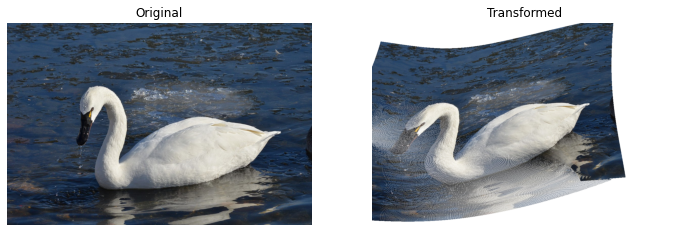

In [61]:
import numpy as np
def locally_affine_transform(img, points, affines, alpha = 1.):
    """
    Locally affine transformation applied on 2D images.
    
    Params
    -------
    img    : npndarray with shape (h, w) or (h, w, c).
    points : control points withs shape (n, 2).
    affines: affine matrices with shape (n, 3, 3).
    alpha  : temperature hyperparameter in assigning weights from distances.
    """
    h, w, d = img.shape[0], img.shape[1], img.size // (img.shape[0] * img.shape[1])

    # 1. compute weights of affine mappings
    coors = np.stack(np.meshgrid(np.arange(w), np.arange(h)))
    coors = np.transpose(coors, (1, 2, 0)).reshape((-1, 2))                      # shape: (hw) x 2
    coors_ =  np.tile(coors.reshape((-1, 1, 2)), (1, points.shape[0], 1))        # shape: (hw) x n x 2
    weights = np.linalg.norm(coors_ - points.reshape((1, -1, 2)), axis = -1)     # shape: (hw) x n
    weights = (weights + 1e-8) ** (-alpha)                                       # shape: (hw) x n
    weights /= weights.sum(axis = 1, keepdims = True)                            # shape: (hw) x n

    # 2. construct homogeneous coordinates
    coors = np.hstack((coors, np.ones((h * w, 1))))                         # shape: (hw) x 3
    coors = np.transpose(np.matmul(affines, coors.T), (2, 0, 1))            # shape: (hw) x n x 3
    coors = (np.expand_dims(weights, axis = -1) * coors).sum(axis = 1)      # shape: (hw) x 3

    # 3. extract the pixels inside the canva
    coors = coors[:,:-1] / coors[:,-1:]
    valid_coors = (coors[:,0] >= 0) & (coors[:,0] <= w - 1) & (coors[:,1] >= 0) & (coors[:,1] <= h - 1)
    valid_coors = valid_coors.reshape((-1, 1))
    coors = np.extract(np.tile(valid_coors, (1, 2)), coors).reshape((-1, 2)).astype('int32')
    img_  = np.extract(np.tile(valid_coors, (1, d)), img.reshape((h*w, -1))).reshape((-1, d))
    
    # 4. map pixels to the new image
    coors = (coors[:,1] * w + coors[:,0]) # coordinates to 1d indices
    new_img = np.full_like(img, 255).reshape((h*w, -1))
    new_img[np.ix_(coors)] = img_ # fill pixels

    return new_img.reshape(img.shape)


import os
from matplotlib import pyplot as plt
from PIL import Image

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\swan.png')))

points = np.array([[600,800],[200,400],[500,300]])
affines = np.array([[[.8,.6,0],[-.6,1.2,20],[0,0,1]],
                    [[.8,-.6,0],[.6,.8,0],[0,0,1]],
                    [[.7,-.2,100],[-.2,.7,200],[0,0,1]]])

new_img = locally_affine_transform(img, points,affines)

plt.figure(figsize = (12, 5))
for i, image, title in zip(range(2), (img, new_img), ('Original', 'Transformed')):
    plt.subplot(1, 2, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
plt.show()

## 自由形变

[图像自由形变](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=796284&tag=1) (free-form deformation, FFD): 对于一个三维空间的图像, 假设有均匀立方网格状的控制点:
$$ \{P_{ijk} = (x_i,y_j,z_k):\ i=0,\dotsc,n_x-1,\ j=0,\dotsc,n_y - 1,\ k=0,\dotsc,n_z - 1\}$$

让这些控制点移动, 则其余的点也会跟着移动. 其余点这样的位移根据 B 样条拟合计算.

<br>

### B 样条

给定四个点 $y_i\ (i=1,2,3,4)$, 定义对应的三次 [均匀 B 样条 (uniform B-spline)](https://mathworld.wolfram.com/B-Spline.html) 为:

$$f(x) = \frac{(1-x)^3}{6}y_1+\frac{3x^3-6x^2+4}{6}y_2+\frac{-3x^3+3x^2+3x+1}{6}y_3+\frac{x^3}{6}y_4
$$

可以发现 B 样条实际上不经过这些点.

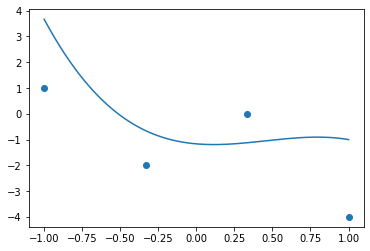

In [1]:
import numpy as np
from matplotlib import pyplot as plt
y = [1,-2,0,-4]
l, r = -1, 1
x = np.linspace(l, r, 1000)
f = ((1-x)**3*y[0] + (3*x**3-6*x*x+4)*y[1] + ((x*x+x-x**3)*3+1)*y[2] + x**3*y[3])/6
plt.plot(x, f)
plt.scatter(np.linspace(l, r, 4), y)
plt.show()

### FFD

假设上述控制点网格 $x,y,z$ 轴的间距为 $l_x,l_y,l_z$. 假设 $\Delta P_{ijk}\in\mathbb R^3$ 表示控制点 $P_{ijk}$ 的位移, 则对于空间中任何一点 $(x,y,z)$, 其位移 $\Delta$ 计算公式为:

$$\Delta = \sum_{i=-1}^2\sum_{j=-1}^2\sum_{k=-1}^2 \Delta P_{i_0+i,\ j_0+j,\ k_0+k}\cdot \beta_i(u)\beta_j(v)\beta_k(w)$$

其中 $i_0= \lfloor \dfrac{x}{l_x}\rfloor,\ j_0= \lfloor \dfrac{y}{l_y}\rfloor,\ k_0= \lfloor \dfrac{z}{l_z}\rfloor$ 是相邻的控制点编号 (整数部分), 以及 $u = \dfrac{x}{l_x}- i_0,\ v= \dfrac{y}{l_y}- j_0,\ w=\dfrac{z}{l_z} - k_0$ 是小数部分. 最后的 $\beta_{?}$ 函数定义为:
$$\left\{
\begin{aligned}
\beta_{-1}(a) &= \frac{(1 - a)^3}{6}\\ 
\beta_{0}(a) &= \frac{3a^3-6a^2+4}{6}\\ 
\beta_{1}(a) &= \frac{-3a^3+3a^3+3a+1}{6}\\ 
\beta_{2}(a) &= \frac{a^3}{6} 
\end{aligned}\right.
$$

In [184]:
import numpy as np
from numba import njit

@njit(cache = True)
def fill_nan(img, neighbor = 3, default = 0):
    """
    Fill nans of a matrix with nearby mean.
    Useful when the transformed image has undefined pixels (coordinates).

    Params
    -------
    img     : ndarray with shape (h, w, c).
    neighbor: value k for when filling a pixel with nanmean of (2k+1)x(2k+1) neighboring pixels.
    default : when all neighbors are nan, set nan to some default value.
    """
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for c in range(img.shape[2]): # channelwise
                if np.isnan(img[i,j,c]):
                    s = 0
                    n = 0
                    for x in range(i - neighbor, i + neighbor + 1):
                        for y in range(j - neighbor, j + neighbor + 1):
                            if 0 <= x < img.shape[0] and 0 <= y < img.shape[1] and not np.isnan(img[x,y,c]):
                                s += img[x,y,c]
                                n += 1
                    img[i,j,c] = s / n if n else default
    return img

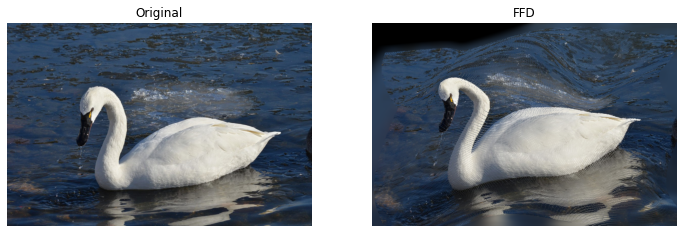

In [188]:
import numpy as np

def free_form_deformation(img, displacement):
    """
    Apply FFD on image given a grid of displacement.
    
    Params
    -------
    img: ndarray with shape (h, w) or (h, w, c).
    displacement: ndarray with shape (h', w', 2), the displacement of control point grid.
    """
    # 1. compute the nearest control points and offsets
    spacings = np.array([i / (j-1) for i, j in zip(img.shape[:2], displacement.shape[:2])])
    ids = [np.arange(l) / s for l, s in zip(img.shape[:2], spacings)]
    ids = np.transpose(np.stack(np.meshgrid(*ids)), (2,1,0)) # shape: h x w x 2
    grids   = ids.astype('int32')
    offsets = ids - grids

    # 2. construct the original coordinates
    new_img = np.zeros_like(img).astype('float')
    coors = np.stack(np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1])))
    coors = np.transpose(coors, (2,1,0)).astype('float')
    
    # 3. compute b-splines for each offsets in advance (time-saving)
    def compute_bspline(num, x):
        if  num == -1: return (1 - x)**3 * .166667
        elif num == 0: return (3*x**2 *(x - 2) + 4) * .166667
        elif num == 1: return (1 - 3*x*(x*(x - 1) - 1)) * .166667
        elif num == 2: return x ** 3 * .166667
    bsplines = [dict([(i, compute_bspline(i, offsets[...,axis])) for i in range(-1, 3)]) for axis in range(2)]
    
    # 4. compute the transformed coordinates according to the rule
    safe_grid = lambda grid, axis: np.clip(grid, 0, displacement.shape[axis] - 1)
    for i in range(-1, 3):
        for j in range(-1, 3):
            coors += displacement[safe_grid(grids[...,0] + i, 0), safe_grid(grids[...,1] + j, 1)] \
                        * np.expand_dims(bsplines[0][i] * bsplines[1][j], axis = -1)
    coors = np.round(coors.reshape((-1, 2)))

    # 5. extract the pixels inside the canva
    h, w, d = img.shape[0], img.shape[1], img.size // (img.shape[0] * img.shape[1])
    valid_coors = (coors[:,0] >= 0) & (coors[:,0] <= h - 1) & (coors[:,1] >= 0) & (coors[:,1] <= w - 1)
    valid_coors = valid_coors.reshape((-1, 1))
    coors = np.extract(np.tile(valid_coors, (1, 2)), coors).reshape((-1, 2)).astype('int32')
    img_  = np.extract(np.tile(valid_coors, (1, d)), img.reshape((h*w, -1))).reshape((-1, d))
    
    # 6. map pixels to the new image
    coors = (coors[:,0] * w + coors[:,1]) # coordinates to 1d indices
    new_img = np.full_like(img, np.nan, dtype = 'float').reshape((h*w, -1))
    new_img[np.ix_(coors)] = img_ # fill pixels
    new_img = new_img.reshape((h, w, -1))

    # 7. fill NaN pixels (pixels not defined by transformation) with nearby values
    new_img = fill_nan(new_img, neighbor = 15, default = 0)
    return new_img.reshape(img.shape).astype(img.dtype)




import os
from matplotlib import pyplot as plt
from PIL import Image

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\swan.png')).resize((600, 400)))

# randomly generate some displacement rule of the control points
np.random.seed(0)
displacement = np.random.randn(7, 7, 2) * 40
displacement[3,3,0] = -50

img_ffd = free_form_deformation(img, displacement)

plt.figure(figsize = (12, 5))
for i, image, title in zip((1, 2), (img, img_ffd), ('Original', 'FFD')):
    plt.subplot(1, 2, i)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
plt.show()

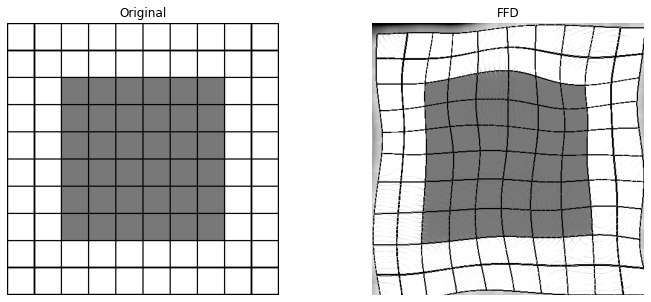

In [190]:
# randomly generate some displacement rule of the control points
np.random.seed(0)
displacement = np.random.randn(7, 7, 2) * 12

# draw the original image
coors = np.meshgrid(np.linspace(-1, 1, 450), np.linspace(-1, 1, 450))
img = np.where((coors[0] > -.6) & (coors[0] < .6) & (coors[1] > -.6) & (coors[1] < .6), 120, 255)
img = np.where(((coors[0]+.005) % .2 <= .01) | ((coors[1]+.005) % .2 <= .01), 0, img)
img = img.astype('uint8')

img_ffd = free_form_deformation(img, displacement)

plt.figure(figsize = (12, 5))
for i, image, title in zip((1, 2), (img, img_ffd), ('Original', 'FFD')):
    plt.subplot(1, 2, i)
    plt.imshow(image, cmap = 'gray')
    plt.title(title)
    plt.axis('off')
plt.show()